In [0]:
!pip install transformers
!pip install wordsegment

In [0]:
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import random
import numpy as np
from tqdm import tqdm_notebook as tqdm, trange
import time
import logging
# logging.basicConfig(level=logging.INFO)
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pd.set_option('max_colwidth', 400)
print(device)

cuda


In [0]:
logger = logging.getLogger('mylogger')
logger.setLevel(logging.DEBUG)
timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(ch)

In [0]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything()

In [0]:
# Applying a first round of text cleaning techniques
from nltk.corpus import stopwords
import nltk
import re
import string
from bs4 import BeautifulSoup
from wordsegment import load, segment
load()

tokenizer = nltk.tokenize.TweetTokenizer(
        strip_handles=True, reduce_len=True)

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def clean_text_no_smiley(text):
    text = BeautifulSoup(text, 'lxml').get_text()
    eyes = "[8:=;]"
    nose = "['`\-]?"
    text = re.sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", " ", text)

    text = re.sub("/", " / ", text)
    text = re.sub('@(\w+)', '', text)

    text = re.sub('#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}', " ", text)
    text = re.sub('#{eyes}#{nose}p+', " ", text)
    text = re.sub('#{eyes}#{nose}\(+|\)+#{nose}#{eyes}', " ", text)
    text = re.sub('#{eyes}#{nose}[\/|l*]', " ", text)
    text = re.sub('<3', " ", text)
    # numbers
    text = re.sub('[-+]?[.\d]*[\d]+[:,.\d]*', " ", text)

    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(
        string.punctuation.replace("'", "")), ' ', text) # don't remove ' in words
    text = re.sub('\n', ' ', text)
    text = ''.join(filter(lambda x: x in string.printable, text))
    # Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    #text = ' '.join(segment(text))
    return text


def text_preprocessing_no_lemmatizer(text):

    nopunc = clean_text_no_smiley(text)

    tokenized_text = tokenizer.tokenize(nopunc)

    combined_text = ' '.join(tokenized_text)
    return combined_text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [0]:
try:
    train = pd.read_csv('input/preprocessed_train.csv')
    print('Training data shape: ', train.shape)
    test = pd.read_csv('input/preprocessed_test.csv')
    print('Testing data shape: ', test.shape)
except:
    train = pd.read_csv('drive/My Drive/NLP_data/train.csv')
    print('Training data shape: ', train.shape)
    test = pd.read_csv('drive/My Drive/NLP_data/test.csv')
    print('Testing data shape: ', test.shape)

    train['text'] = train['text'].apply(
        lambda x: text_preprocessing_no_lemmatizer(x))
    test['text'] = test['text'].apply(
        lambda x: text_preprocessing_no_lemmatizer(x))

    train.drop(["keyword", "location"], axis=1, inplace=True)
    test.drop(["keyword", "location"], axis=1, inplace=True)

    train.to_csv('input/preprocessed_train.csv')
    test.to_csv('input/preprocessed_test.csv')


train[['text']].head(5)

Training data shape:  (7613, 4)
Testing data shape:  (3263, 3)


,text
0,our deeds are the reason of this earthquake may allah forgive us all
1,forest fire near la ronge sask canada
2,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
3,people receive wildfires evacuation orders in california
4,just got sent this photo from ruby alaska as smoke from wildfires pours into school


In [0]:
# custom dataset
class BertDataset(Dataset):
    def __init__(self, input_ids, segment_ids, labels=None):
        self.input_ids = input_ids
        self.segment_ids = segment_ids

    def __len__(self):
        return (len(self.input_ids))
    
    def __getitem__(self, i):
        return (self.input_ids[i], self.segment_ids[i])

In [0]:
model_type = 'bert-large-uncased'
bertTokenizer = BertTokenizer.from_pretrained(model_type)
max_len_train = 0
max_len_test = 0

# Find the longest sentence
for sentence in train["text"]:
    input_ids = bertTokenizer.encode(sentence, add_special_tokens=True)
    max_len_train = max(max_len_train, len(input_ids))

for sentence in test["text"]:
    input_ids = bertTokenizer.encode(sentence, add_special_tokens=True)
    max_len_test = max(max_len_test, len(input_ids))

print('Max sentence length in training data: ', max_len_train)
print('Max sentence length in testing data: ', max_len_test)

Max sentence length in training data:  41
Max sentence length in testing data:  39


In [0]:
max_len=64

In [0]:
def convert_df_to_BERT_input(sequences, bertTokenizer):
    input_ids = []
    segment_ids = []
    attention_masks = []
  
    for index, sequence in enumerate(sequences):
        # Split the sentence into tokens.
        encoded_dict = bertTokenizer.encode_plus(sequence, add_special_tokens=True, max_length=max_len, 
                                              pad_to_max_length=True,
                                              return_attention_mask = True,
                                              return_token_type_ids = True,
                                              return_tensors = 'pt',     # Return pytorch tensors.
                                              )   
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        segment_ids.append(encoded_dict['token_type_ids'])
        
    return (input_ids, attention_masks, segment_ids)

In [0]:
#bert_input = convert_df_to_BERT_input(train["text"])
input_ids, attention_masks, segment_ids = convert_df_to_BERT_input(train['text'], bertTokenizer)

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
segment_ids = torch.cat(segment_ids, dim=0)
labels = torch.tensor(train['target'], dtype=torch.long) 

dataset = TensorDataset(input_ids, attention_masks, segment_ids)

In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

embedding_dataloader = DataLoader(
            dataset, # The validation samples.
            sampler = SequentialSampler(dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [0]:
bert_model = BertModel.from_pretrained(model_type, output_hidden_states=True)
# Put the model in "evaluation" mode, meaning feed-forward operation.
bert_model.to(device)
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [0]:
def create_embeddings(embedding_dataloader):
  bert_embeddings = None

  with torch.no_grad():
      for batch in embedding_dataloader:
        batch = tuple(t.to(device) for t in batch)
        with torch.no_grad():
          inputs = {'input_ids': batch[0],
                    'attention_mask': batch[1],
                    'token_type_ids': batch[2]
                    }
          _, _, hidden_states = bert_model(**inputs)
          # hidden states length is 13 (1 embedding + 12 hidden layers)

          # second to last 
          hidden_layer = hidden_states[-2]

          if bert_embeddings is None:
            bert_embeddings = torch.mean(hidden_layer, dim=1)
          else:
            bert_embeddings = torch.cat([bert_embeddings, torch.mean(hidden_layer, dim=1)], dim=0)

  return bert_embeddings                 

In [0]:
bert_embeddings = create_embeddings(embedding_dataloader)

In [0]:
print(len(bert_embeddings))

7613


In [0]:
from sklearn.model_selection import train_test_split

target = train["target"]
train_data, validation_data, train_target, validation_target = train_test_split(
   bert_embeddings, labels, test_size=0.2, random_state=1000)
test_data = test["text"]

In [0]:
train_dataset = TensorDataset(train_data, train_target)
validation_dataset = TensorDataset(validation_data, validation_target)

In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            validation_dataset, # The validation samples.
            sampler = SequentialSampler(validation_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [0]:
# hyperparameters
seq_length = 768 if model_type == "bert-base-uncased" else 1024
hidden_dim = seq_length
learning_rate = 1e-5 #1e-5
num_epochs = 10
patience = 2
num_layers = 2
is_bidirectional = True

In [0]:
print(seq_length)

1024


In [0]:
class TwitterClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, bidirectional):
        super().__init__()
       
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, 
                            num_layers=num_layers, bidirectional=bidirectional)
        
        
        #hidden_dim * num_layers * (1+self.config.bidirectional), 2
        linear_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(linear_dim, 2)
          
    def forward(self, sentence):
        # input shape: seq_len, batch, input_size
        packed_output, (hidden, cell) = self.lstm(sentence.view(1, sentence.shape[0], -1))
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        #output, hidden = self.dropout(lstm_out.view(1, -1))
        y = self.fc(hidden)
        log_probs = F.log_softmax(y.squeeze(0), dim=0)
        return log_probs

In [0]:
model = TwitterClassifier(seq_length, hidden_dim, num_layers, is_bidirectional).to(device)
model

TwitterClassifier(
  (lstm): LSTM(1024, 1024, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=2048, out_features=2, bias=True)
)

In [0]:
from sklearn.metrics import classification_report
def class_accuracy(preds, y):
    """
    Returns accuracy per batch
    """
    rounded_preds = preds.argmax(1)
    correct = (rounded_preds == y).float() #convert into float for division 
    #target_names = ['class 0', 'class 1', 'class 2', 'class 3']
    #print(classification_report(rounded_preds.cpu().numpy(), y.cpu().numpy(), target_names=target_names))
    acc = correct.sum() / len(correct)
    return acc

In [0]:
from sklearn.metrics import accuracy_score, f1_score
import torch.nn.functional as F
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    all_predictions = torch.tensor([], dtype=torch.long);
    all_labels = torch.tensor([], dtype=torch.long);
    for batch in iterator:
        batch = tuple(t.to(device) for t in batch)
        optimizer.zero_grad()
                
        predictions = model(batch[0])

        loss = criterion(predictions, batch[1])
        
        acc = class_accuracy(predictions, batch[1])
        
        all_predictions = torch.cat((all_predictions, predictions.detach().cpu().argmax(1)), dim=0)
        all_labels = torch.cat((all_labels, batch[1].detach().cpu()), dim=0)

        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    f1 = f1_score(all_predictions, all_labels)
    return epoch_loss / len(iterator), epoch_acc / len(iterator), f1

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    all_predictions = torch.tensor([], dtype=torch.long);
    all_labels = torch.tensor([], dtype=torch.long);
    with torch.no_grad():
    
        for batch in iterator:
            batch = tuple(t.to(device) for t in batch)
            predictions = model(batch[0])
            loss = criterion(predictions, batch[1])
            
            acc = class_accuracy(predictions, batch[1])

            all_predictions = torch.cat((all_predictions, predictions.detach().cpu().argmax(1)), dim=0)
            all_labels = torch.cat((all_labels, batch[1].detach().cpu()), dim=0)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), f1_score(all_predictions, all_labels)

In [0]:
import time

best_valid_loss = float('inf')

criterion = nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

all_train_loss = []
all_valid_loss = []
all_train_acc = []
all_valid_acc = []

early_stop = 0
for epoch in range(num_epochs):

    start_time = time.time()
    
    train_loss, train_acc, train_f1 = train(model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc, val_f1 = evaluate(model, validation_dataloader, criterion)

    all_train_loss.append(train_loss)
    all_train_acc.append(train_acc)
    all_valid_loss.append(valid_loss)
    all_valid_acc.append(valid_acc)
    '''
    if best_F1 < valid_F1:
      early_stop = 0
      best_f1 = valid_F1
    else:
      early_stop += 1

    if early_stop >= patience:
      break
'''
    end_time = time.time()

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {elapsed_mins}m {elapsed_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print(f'\t Train F1: {train_f1:.3f} |')
    print(f'\t Val. F1: {val_f1:.3f} |')
    #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 3.389 | Train Acc: 74.29%
	 Val. Loss: 3.269 |  Val. Acc: 78.32%
	 Train F1: 0.700 |
	 Val. F1: 0.738 |
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 3.271 | Train Acc: 78.08%
	 Val. Loss: 3.225 |  Val. Acc: 81.31%
	 Train F1: 0.741 |
	 Val. F1: 0.775 |
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 3.242 | Train Acc: 79.84%
	 Val. Loss: 3.207 |  Val. Acc: 82.81%
	 Train F1: 0.763 |
	 Val. F1: 0.793 |
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 3.227 | Train Acc: 80.48%
	 Val. Loss: 3.196 |  Val. Acc: 82.68%
	 Train F1: 0.769 |
	 Val. F1: 0.793 |
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 3.216 | Train Acc: 80.66%
	 Val. Loss: 3.187 |  Val. Acc: 83.00%
	 Train F1: 0.774 |
	 Val. F1: 0.795 |
Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 3.207 | Train Acc: 81.22%
	 Val. Loss: 3.181 |  Val. Acc: 82.48%
	 Train F1: 0.780 |
	 Val. F1: 0.788 |
Epoch: 07 | Epoch Time: 0m 2s
	Train Loss: 3.203 | Train Acc: 81.52%
	 Val. Loss: 3.178 |  Val. Acc: 82.74%
	 Train F1

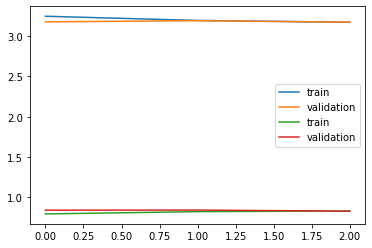

In [0]:
plt.plot(all_train_loss, label='train')
plt.plot(all_valid_loss, label='validation')
plt.legend()
plt.plot(all_train_acc, label='train')
plt.plot(all_valid_acc, label='validation')
plt.legend()

In [0]:
#bert_input = convert_df_to_BERT_input(train["text"])
input_ids, attention_masks, segment_ids = convert_df_to_BERT_input(test['text'], bertTokenizer)

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
segment_ids = torch.cat(segment_ids, dim=0)


dataset = TensorDataset(input_ids, attention_masks, segment_ids)

In [0]:
embedding_dataloader = DataLoader(
            dataset,
            sampler = SequentialSampler(dataset),
            batch_size = batch_size
        )

In [0]:
test_bert_embeddings = create_embeddings(embedding_dataloader)
test_dataset = TensorDataset(test_bert_embeddings)
test_dataloader = DataLoader(
            test_dataset, 
            sampler = SequentialSampler(test_dataset), 
            batch_size = batch_size
        )
'''
data = DataLoader(bert_input)
bert_embeddings = []
with torch.no_grad():
    for index, (input_ids, segment_ids) in enumerate(data):
        tokens_tensor = torch.tensor([input_ids])
        segments_tensors = torch.tensor([segment_ids])
        _, _, hidden_states = bert_model(tokens_tensor, segments_tensors)
        # hidden states length is 13 (1 embedding + 12 hidden layers)
        hidden_layers = hidden_states[1:]
        
        token_vecs = hidden_layers[-1][0]

        # Calculate the average of all token vectors.
        sentence_embedding = torch.mean(token_vecs, dim=0)
        bert_embeddings.append(sentence_embedding)            
'''

'\ndata = DataLoader(bert_input)\nbert_embeddings = []\nwith torch.no_grad():\n    for index, (input_ids, segment_ids) in enumerate(data):\n        tokens_tensor = torch.tensor([input_ids])\n        segments_tensors = torch.tensor([segment_ids])\n        _, _, hidden_states = bert_model(tokens_tensor, segments_tensors)\n        # hidden states length is 13 (1 embedding + 12 hidden layers)\n        hidden_layers = hidden_states[1:]\n        \n        token_vecs = hidden_layers[-1][0]\n\n        # Calculate the average of all token vectors.\n        sentence_embedding = torch.mean(token_vecs, dim=0)\n        bert_embeddings.append(sentence_embedding)            \n'

In [0]:
def predict_func(iterator):
    predictions = torch.tensor([], dtype=torch.long)
    for batch in iterator:
        batch = tuple(t.to(device) for t in batch)
        input = batch[0]
        with torch.no_grad():
            output = model(input)
            predictions = torch.cat((predictions, output.detach().cpu().argmax(1)))

    return predictions

predictions = predict_func(test_dataloader)
print(len(predictions))


3263


In [0]:
print(predictions[:20])

tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])


In [0]:
def submission(submission_file_path,submission_data):
    sample_submission = pd.read_csv(submission_file_path)
    sample_submission["target"] = [data.item() for data in submission_data]
    print(sample_submission["target"])
    sample_submission.to_csv("submission.csv", index=False)

In [0]:
submission_file_path = "drive/My Drive/NLP_data/sample_submission.csv"
submission(submission_file_path,predictions)

0       1
1       1
2       1
3       1
4       1
       ..
3258    0
3259    1
3260    1
3261    1
3262    1
Name: target, Length: 3263, dtype: int64
